This tutorial example is on the application of CNN image segmentation on salt identification. The train and test data were gotten from TGS-Kaggle Salt Identification challenge in 2018: https://www.kaggle.com/c/tgs-salt-identification-challenge/ . A majority of the code in this notebook was extracted from: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277 by Kjetil Åmdal-Sævik.

The train data consist of 4000 (101 by 101) seismic patches and 4000 corresponding masks indicating regions of salt presence or not. The test data consist of 18000 (101 by 101) seismic patches. The aim of the competition was to predict regions of salt or no salt on the test seismic patches.

In this example, we will be covering how to use th U-Net model (a popular type of image segmentation model) to identify salt regions from seismic image patches and the following;

* Loading the data and preparation
* Training the U-Net
* Saving the trained model
* Prediction
* Visualizations

In [ ]:
# import required libraries and packages

import os, sys, random, warnings
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf

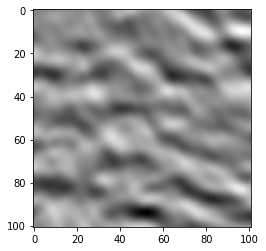

In [ ]:
img = load_img("/content/drive/MyDrive/train/images/000e218f21.png")
plt.imshow(img)

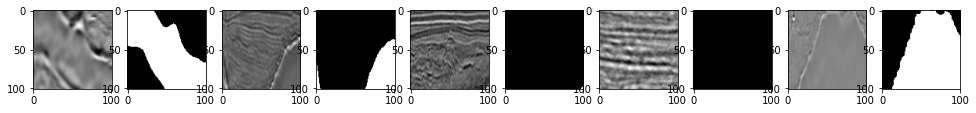

In [ ]:
# Display some example image and mask patches

ids= ['0a1742c740','5b7c160d0d','6c40978ddf','7dfdf6eeb8','1ee0d5b4d0']

plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('/content/drive/MyDrive/train/images/' + img_name + '.png')
    img_mask = load_img('/content/drive/MyDrive/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()



#Dark patches indicate no salts in the image

### Loading the data and preparation

Getting training image ids to load image and mask data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_train = '/content/drive/MyDrive/train/'   # path to train images and masks
path_test = '/content/drive/MyDrive/test/'     # path to test images

train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [ ]:
len(train_ids), len(test_ids)

(4020, 13406)

In [ ]:
train_ids[:5]

['f8b721f632.png',
 'cb0d3e8399.png',
 'a038a2d781.png',
 '13f3daf89f.png',
 '9a6c280d8d.png']

Image and mask patches will be resized to 64px by 64px from original 101px by 101px

In [ ]:
im_height = 64    # new height
im_width = 64    # new width
im_chan = 1     # number of image channel

Creating empty arrays to hold resized train and test image data

In [ ]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.bool)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
X_train.shape, Y_train.shape

((4020, 64, 64, 1), (4020, 64, 64, 1))

In [ ]:
X_train[0].shape

(64, 64, 1)

In [ ]:
X_train[0]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [ ]:
Y_train[1]

array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

Resizing train images and masks

In [18]:
path = path_train
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (64, 64, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    try:
      mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    except:
      print (id_)
    else:
      mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (64, 64, 1), mode='constant', preserve_range=True)

print('Done!')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/4020 [00:00<?, ?it/s]

0fd38464c3 (1).png
f409d55fee (1).png
5f397e0074 (1).png
54a3636ba6 (1).png
c8adc706f5 (1).png
0926b7396b (1).png
d0aeb260e8 (1).png
d059fcb2fd (1).png
59597a8431 (1).png
47048ac10a (1).png
6c793e5879 (1).png
5ef096aeac (1).png
30d4fb116b (1).png
146ec37657 (1).png
1ac4fd8022 (1).png
d1857e0577 (1).png
5f8b4540fd (1).png
ede9c03a6f (1).png
c9142b341c (1).png
4680bc7373 (1).png
Done!


In [19]:
X_train.shape

(4020, 64, 64, 1)

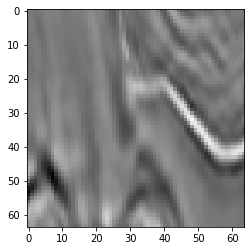

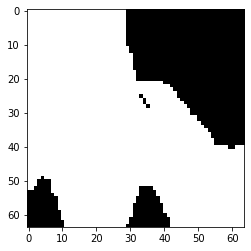

In [20]:
# Quakity check to see if training data looks all right

ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [ ]:
plt.savefig("hey.png")

Loading and resizing test image patches

In [22]:
# creating empty test image arrays

X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)

In [23]:
X_test.shape

(13406, 64, 64, 1)

In [24]:

path = path_test
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (64, 64, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/13406 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [25]:
X_train.shape, X_test.shape, Y_train.shape

((4020, 64, 64, 1), (13406, 64, 64, 1), (4020, 64, 64, 1))


































### Model Training with the U-Net Architecture

![U-Net architecture.png](images/u-net-architecture.png)

In [26]:
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
c1

<KerasTensor: shape=(None, 64, 64, 8) dtype=float32 (created by layer 'conv2d_1')>

In [27]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)


# CONTRASTIVE and ENCODING PART
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

# EXPANSIVE and DECODING PART
u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

# OUTPUT LAYER
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 lambda_1 (Lambda)              (None, 64, 64, 1)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 8)    80          ['lambda_1[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 64, 64, 8)    584         ['conv2d_2[0][0]']               
                                                                                              

### Saving the trained model

Specify model hyperparameters, and call backs to save the model

In [29]:
X_train.shape

(4020, 64, 64, 1)

In [30]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('TGS-salt-model-1.h5', verbose=1, save_best_only=True)

In [31]:
epochs = 15
batch_size = 8
validation_size = 0.2

Train the model

In [32]:
results = model.fit(X_train, Y_train, validation_split=validation_size, 
                    batch_size=batch_size, epochs=epochs, callbacks=[earlystopper, checkpointer])

Epoch 1/15
402/402 [==============================] - ETA: 0s - loss: 0.5481 - accuracy: 0.7384
Epoch 1: val_loss improved from inf to 0.50380, saving model to TGS-salt-model-1.h5
402/402 [==============================] - 80s 194ms/step - loss: 0.5481 - accuracy: 0.7384 - val_loss: 0.5038 - val_accuracy: 0.7377
Epoch 2/15
402/402 [==============================] - ETA: 0s - loss: 0.4369 - accuracy: 0.8001
Epoch 2: val_loss improved from 0.50380 to 0.38303, saving model to TGS-salt-model-1.h5
402/402 [==============================] - 81s 201ms/step - loss: 0.4369 - accuracy: 0.8001 - val_loss: 0.3830 - val_accuracy: 0.8487
Epoch 3/15
402/402 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.8587
Epoch 3: val_loss improved from 0.38303 to 0.33256, saving model to TGS-salt-model-1.h5
402/402 [==============================] - 79s 197ms/step - loss: 0.3603 - accuracy: 0.8587 - val_loss: 0.3326 - val_accuracy: 0.8739
Epoch 4/15
402/402 [==============================

### Prediction

Making use of the best saved model to make train, test prediction

In [34]:
model.save("Segementation.h5")

In [35]:
# Predict on train, val and test
model = load_model('/content/Segementation')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.8):], verbose=1)

preds_test = model.predict(X_test, verbose=1)    # test data

419/419 [==============================] - 62s 148ms/step


In [ ]:
 int(X_train.shape[0]*0.8)

NameError: ignored

In [ ]:
preds_test.shape

In [ ]:
preds_train

In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
preds_train_t

In [ ]:
preds_train_t.shape, preds_val_t.shape, preds_test_t.shape

### Visualizations

Visualizing the predicted samples (train and test)

In [ ]:
# Train samples predicted

ix = random.randint(0, len(preds_train_t))
ix
# imshow(np.squeeze(X_train[ix]))
# plt.show()
# imshow(np.squeeze(Y_train[ix]))
# plt.show()
# tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
# imshow(np.dstack((tmp,tmp,tmp)))
# plt.show()

513

In [36]:
# Train samples predicted

ix = random.randint(0, len(preds_train_t))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

NameError: ignored

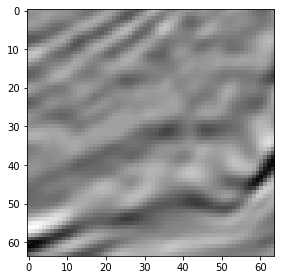

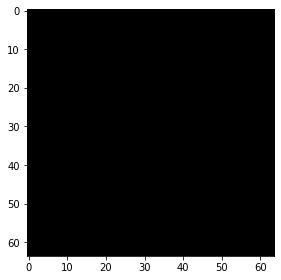

In [ ]:
# Test samples predicted

ix = random.randint(0, len(preds_test_t))
imshow(np.squeeze(X_test[ix]))
plt.show()
tmp = np.squeeze(preds_test_t[ix]).astype(np.float32)
imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

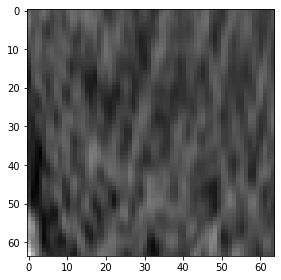

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


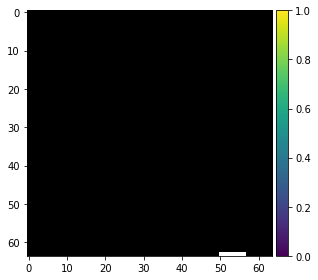

In [ ]:
# Test samples predicted

ix = random.randint(0, len(preds_test_t))
imshow(np.squeeze(X_test[ix]))
plt.show()
tmp = np.squeeze(preds_test_t[ix]).astype(np.float32)
imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

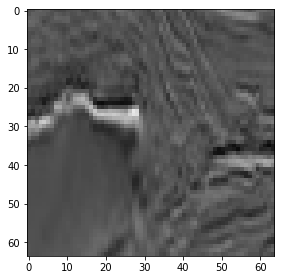

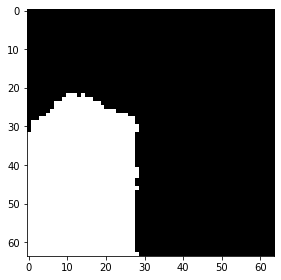

In [ ]:
# Test samples predicted

ix = random.randint(0, len(preds_test_t))
imshow(np.squeeze(X_test[ix]))
plt.show()
tmp = np.squeeze(preds_test_t[ix]).astype(np.float32)
imshow(np.dstack((tmp,tmp,tmp)))
plt.show()